# Poisson and 0-inflated

##### Keywords: glm, regression, poisson regression, link-function, zero-inflated, mixture model

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Monks with different exposure times

$$
y_i \sim Poisson(\lambda_i)\\
log(\lambda_i) = \alpha + \beta x_i
$$

$$
y_i \sim Poisson(\lambda_i)\\
log(\lambda_i) = log(\frac{\mu_i}{\tau_i}) = \alpha + \beta x_i
$$

$$
y_i \sim Poisson(\mu_i)\\
log(\mu_i) = log(\tau_i) + \alpha + \beta x_i
$$

In [2]:
from scipy.stats import poisson
num_days=30
y=poisson.rvs(mu=1.5, size=30)

In [3]:
y

array([1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 4, 2, 4, 1, 2, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 2, 1, 1, 3])

In [4]:
num_weeks=4
y_new = poisson.rvs(mu=0.5*7, size=num_weeks)#per week
y_new

array([5, 0, 3, 3])

In [5]:
yall=list(y) + list(y_new)
exposure=len(y)*[1]+len(y_new)*[7]
monastery = len(y)*[0]+len(y_new)*[1]
df=pd.DataFrame.from_dict(dict(y=yall, days=exposure, monastery=monastery))
df

,days,monastery,y
0,1,0,1
1,1,0,2
2,1,0,1
3,1,0,3
4,1,0,1
5,1,0,1
6,1,0,1
7,1,0,1
8,1,0,1
9,1,0,1


In [6]:
import theano.tensor as t
with pm.Model() as model1:
    alpha=pm.Normal("alpha", 0,100)
    beta=pm.Normal("beta", 0,1)
    logmu = t.log(df.days)+alpha+beta*df.monastery
    y = pm.Poisson("obsv", mu=t.exp(logmu), observed=df.y)
    lambda0 = pm.Deterministic("lambda0", t.exp(alpha))
    lambda1 = pm.Deterministic("lambda1", t.exp(alpha + beta))

In [7]:
with model1:
    trace1 = pm.sample(5000)

100%|██████████| 5000/5000 [00:05<00:00, 948.05it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ea526a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121b5bf60>]], dtype=object)

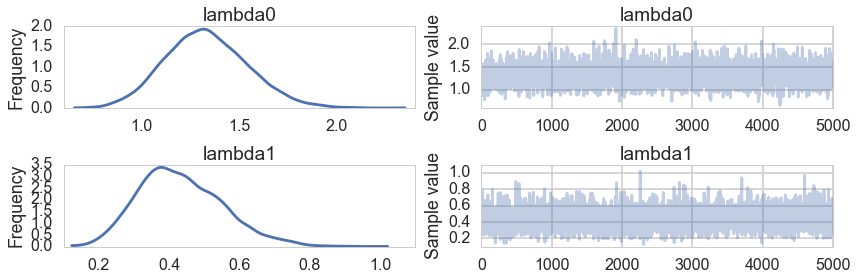

In [8]:
pm.traceplot(trace1, varnames=['lambda0', 'lambda1'])

In [9]:
pm.summary(trace1, varnames=['lambda0', 'lambda1'])


lambda0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.329            0.210            0.004            [0.924, 1.731]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.941          1.183          1.319          1.465          1.767


lambda1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.432            0.119            0.002            [0.219, 0.674]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.231          0.347          0.421          0.511          0.695



One tends to use Poisson over Binomial in the scenario of low counts where the counts *could* be very large. Kidney cancers for example. In a sense you can think of this indeed as a binomial with low probability of "success" and a large number of trials. This limit of the Binomial distribution is the Poisson distribution.

## Monks who drink: the Zero-Inflated Poisson Model

From McElreath:

>Now imagine that the monks take breaks on some days. On those days, no manuscripts are completed. Instead, the wine cellar is opened and more earthly delights are practiced. As the monastery owner, you'd like to know how often the monks drink. The obstacle for inference is that there will be zeros on honest non-drinking days, as well, just by chance. So how can you estimate the number of days spent drinking?

![](images/a-st-bernardus-prior-8.jpg)

The kind of model used to solve this problem is called a **Mixture Model**. We'll see these in more detail next week, but here is a simple version that arises in Poisson regression.

Let $p$ be the probability that the monks spend the day drinking, and $\lambda$ be the mean number of manuscripts completed, when they work.


### Likelihood

The likelihood of observing 0 manuscripts produced is is:

 $$\cal{L}(y=0) = p + (1-p) e^{-\lambda},$$

since the Poisson likelihood of $y$ is $ \lambda^y exp(–\lambda)/y!$

Likelihood of a non-zero $y$ is:

 $$\cal{L}(y \ne 0) = (1-p) \frac{\lambda^y e^{-\lambda}}{y!}$$

This model can be described by this diagram, taken from Mc-Elreath

![](images/zinfmonks.png)


### Generating the data

We're throwing bernoullis for whether a given day in the year is a drinking day or not...

In [21]:
from scipy.stats import binom
p_drink=0.2
rate_work=1
N=365
drink=binom.rvs(n=1, p=p_drink, size=N)
drink

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1,

On days we dont drink, we produce some work...though it might be 0 work...

In [22]:
y = ( 1 - drink)*poisson.rvs(mu=rate_work, size=N)
y

array([0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       3, 2, 1, 1, 2, 3, 0, 0, 2, 0, 0, 2, 0, 4, 2, 1, 0, 1, 2, 0, 1, 1, 2,
       2, 1, 0, 0, 1, 2, 1, 0, 3, 0, 1, 1, 0, 1, 3, 1, 0, 2, 0, 0, 3, 1, 0,
       1, 1, 0, 0, 2, 1, 0, 0, 3, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2,
       2, 1, 0, 2, 0, 0, 2, 1, 0, 1, 1, 2, 0, 2, 1, 0, 2, 1, 1, 1, 2, 2, 3,
       0, 3, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 3, 1, 0, 0, 0, 0, 1,
       0, 2, 1, 0, 0, 3, 0, 1, 0, 2, 0, 2, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 2, 2, 2, 3, 0, 1, 0, 0, 0, 2, 0, 1, 0, 1, 0, 4, 0, 0, 0, 0, 2,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 1, 2,
       0, 3, 0, 1, 0, 2, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 3, 2, 0, 1, 0, 5, 1,
       0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 1, 0, 3, 2,
       0, 2, 1, 1, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 2, 2, 1, 0, 2, 3, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 1,
       0, 0,

Lets manufacture a histogram of manuscripts produced in a day.

In [23]:
zeros_drink=np.sum(drink)
a=drink==0
b=y==0
zeros_work=np.sum(a & b)
zeros_drink, zeros_work, np.sum(b)

(72, 99, 171)

(array([ 171.,  110.,   60.,   21.,    2.,    1.,    0.,    0.,    0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

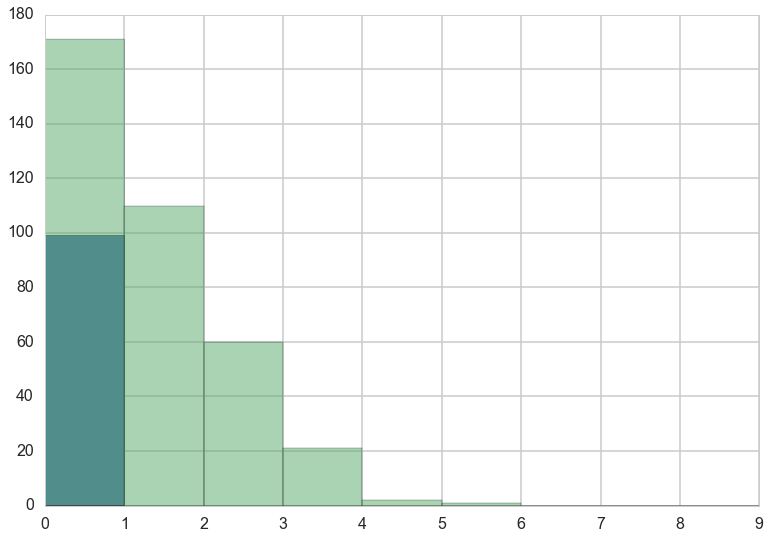

In [24]:
plt.hist(zeros_work*[0], bins=np.arange(10))
plt.hist(y, bins=np.arange(10), alpha=0.5)

## MCMC on the model

The likelihood that combines the two cases considered above is called the **Zero Inflated poisson**. It has two arguments, the Poisson rate parameter, and the proportion of poisson variates (theta and psi in pymc).

In [25]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [26]:
with pm.Model() as model2:
    alphalam=pm.Normal("alphalam", 0,10)
    alphap=pm.Normal("alphap", 0,1)
    #regression models with intercept only
    logmu = alphalam
    logitp = alphap
    y = pm.ZeroInflatedPoisson("obsv", theta=t.exp(logmu), psi=tinvlogit(logitp), observed=y)
    lam = pm.Deterministic("lam", t.exp(logmu))
    p = pm.Deterministic("p", tinvlogit(logitp))

In [27]:
with model2:
    trace2=pm.sample(2000)

100%|██████████| 2000/2000 [00:01<00:00, 1256.31it/s]


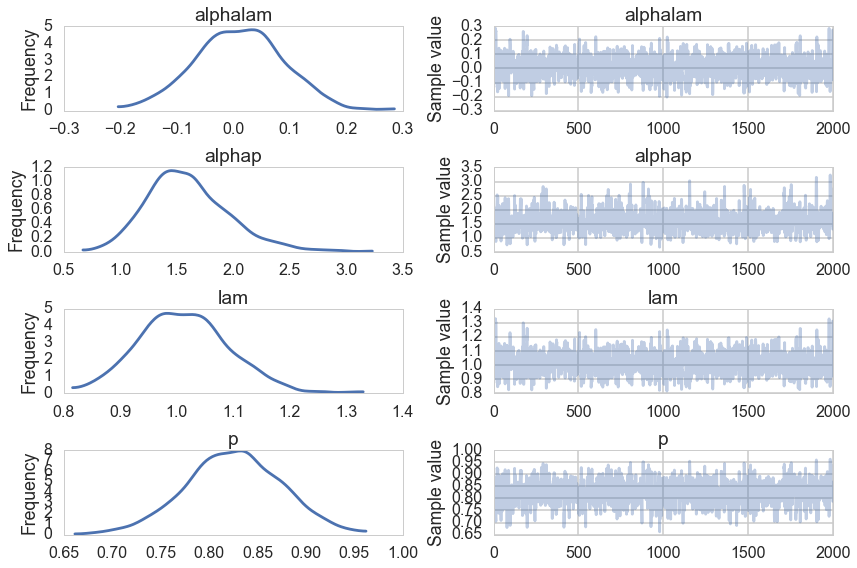

In [29]:
pm.traceplot(trace2);